### Import Library

In [164]:
import pandas as pd
from sklearn.model_selection import train_test_split
import math
import random
import itertools
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

### Import Data

In [165]:
X_data = pd.read_csv('dataset/fitur.csv')
X = X_data.values
X

array([[0.5137741 , 0.74558996, 0.78156792, 0.20550526],
       [0.59937033, 0.65895727, 0.78575703, 0.28307523],
       [0.48248721, 0.67346139, 0.80670257, 0.25265383],
       ...,
       [0.48465171, 0.03606429, 0.09694794, 0.0706769 ],
       [0.454939  , 0.24382595, 0.3967684 , 0.07145811],
       [0.67827627, 0.81575853, 0.7432675 , 0.49119985]])

In [166]:
y_data = pd.read_csv('dataset/target.csv')
y = y_data.values
y

array([[0.70550539],
       [0.73579959],
       [0.71103991],
       ...,
       [0.20128168],
       [0.40576755],
       [0.8311972 ]])

### Split Data

In [167]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [168]:
X_test = pd.DataFrame(X_test, columns=X_data.columns)
y_test = pd.DataFrame(y_test, columns=y_data.columns)
X_test.to_csv('dataset/X_test.csv', index=False)
y_test.to_csv('dataset/y_test.csv', index=False)

### Modeling

##### Inisialisasi bobot dan bias

In [169]:
def inisialisasi(hidden_layer, hidden_neuron):
    bobot = []
    bias = []
    for i in range(hidden_layer):
        if i == 0:
            bobot.append([[random.uniform(0, 1) for _ in range(hidden_neuron[i])] for _ in range(4)])
        else:
            bobot.append([[random.uniform(0, 1) for _ in range(hidden_neuron[i])] for _ in range(hidden_neuron[i-1])])
        bias.append([random.uniform(0, 1) for _ in range(hidden_neuron[i])])
    bobot_output = [random.uniform(0, 1) for _ in range(hidden_neuron[-1])]
    bias_output = random.uniform(0, 1)
    return bobot, bias, bobot_output, bias_output

##### Fungsi aktivasi

In [170]:
def aktivasiX(activ, x): 
    # aktivasi relu
    if activ == 'relu':
        if x >= 0:
            return x
        else:
            return 0
    # aktivasi sigmoid
    elif activ == 'sigmoid':
        return 1 / (1 + math.exp(-x))
    # aktivasi softmax
    elif activ == 'softmax':
        return 1
    # aktivasi tanh
    else:
        return (math.exp(x) - math.exp(-x)) / (math.exp(x) + math.exp(-x))

def turunanaktivasiX(activ, x): 
    # turunan aktivasi relu
    if activ == 'relu':
        if x > 0:
            return 1
        else:
            return 0
    # turunan aktivasi sigmoid
    elif activ == 'sigmoid':
        sig = 1 / (1 + math.exp(-x))
        return sig * (1 - sig)
    # turunan aktivasi softmax
    elif activ == 'softmax':
        return 0
    # turunan aktivasi tanh
    else:
        tan = (math.exp(x) - math.exp(-x)) / (math.exp(x) + math.exp(-x))
        return 1 - (tan) ** 2

##### Fungsi Training

In [171]:
def ann(epochs, hidden_layer, hidden_neuron, activation, lr, X_train, y_train, bobot, bias, bobot_output, bias_output):
    best_mse = float('inf')
    best_bobot = bobot
    best_bias = bias
    best_bobot_output = bobot_output
    best_bias_output = bias_output
    for epoch in range(epochs):
        total_error = 0
        for i in range(len(X_train)):
            # FEEDFORWARD
            # Operasi pada Hidden Layer
            # penjumlahan terbobot dan aktivasi
            aktivasi_hidden = [] # menampung keseluruhan aktivasi
            for j in range(hidden_layer):
                aktivasi_hidden_temp = [] # menampung aktivasi setiap hiden layer (sementara)
                for k in range(hidden_neuron[j]):
                    sumXbobot = 0 # hasil penjumlahan terbobot
                    if j == 0: # untuk hidden neuron pertama (karena neuron input tidak terdefinisi)
                        for l in range(4): # jumlah neuron layer sebelumnya/ neuron input = 4
                            sumXbobot += bobot[j][l][k] * X_train[i][l]
                    else:
                        for l in range(hidden_neuron[j-1]): # jumlah neuron layer sebelumnya
                            sumXbobot += bobot[j][l][k] * aktivasi_hidden[j-1][l]
                    # menambahkan bias pada hasil penjumlahan terbobot
                    sumXbobotbias = bias[j][k] + sumXbobot
                    # aktivasi
                    aktivasi_hidden_temp.append(aktivasiX(activation, sumXbobotbias))
                # menambahkan hasil aktivasi tiap hidden_layer ke penampung keseluruhan
                aktivasi_hidden.append(aktivasi_hidden_temp)

            # Operasi pada Output Layer
            # perkalian
            sumZbobotoutput = 0 # hasil penjumlahan terbobot di output layer
            for j in range(hidden_neuron[-1]):
                sumZbobotoutput += bobot_output[j] * aktivasi_hidden[-1][j]
            # menambahkan bias pada hasil penjumlahan terbobot di output layer
            sumZbobotoutput_biasoutput = bias_output + sumZbobotoutput
            # aktivasi
            prediksi = aktivasiX(activation, sumZbobotoutput_biasoutput)

            # Hitung Error (total error untuk menghitung MSE)
            error = y_train[i][0] - prediksi
            total_error += (error ** 2)

        # BACKPROPAGATION
        # error output layer
        error_output = error * turunanaktivasiX(activation, prediksi)
        # inisialisasi error setiap neuron di hidden layer
        error_nuron_hidden = []
        for i in range(hidden_layer):
            error_nuron_hidden.append(np.zeros(hidden_neuron[i]).tolist())
        # error setiap neuron di hidden layer
        for i in range(hidden_layer):
            for j in range(hidden_neuron[-(i+1)]): # mulai dari hidden layer terakhir
                if i == 0: # hidden terakhir akan melibatkan error output
                    sumErrorBobotSetelah = 0
                    sumErrorBobotSetelah += error_output * bobot_output[j]
                    # sum dikalikan turunan input
                    error_nuron_hidden[-(i+1)][j] = sumErrorBobotSetelah * turunanaktivasiX(activation, aktivasi_hidden[-(i+1)][j]) 
                else:
                    sumErrorBobotSetelah = 0
                    for k in range(hidden_neuron[-(i)]): # hidden layer yang 1 lebihnya
                        sumErrorBobotSetelah += error_nuron_hidden[-(i)][k] * bobot[-(i)][j][k]
                        # sum dikalikan turunan input
                        error_nuron_hidden[-(i+1)][j] = sumErrorBobotSetelah * turunanaktivasiX(activation, aktivasi_hidden[-(i+1)][j]) 
        # memperbaiki bobot dan bias
        for i in range(len(X_train)):
            for j in range(hidden_layer):
                for k in range(hidden_neuron[j]):
                    # memperbaiki bobot
                    if j == 0:
                        for l in range(4):
                            bobot[j][l][k] += lr * error_nuron_hidden[j][k] * X_train[i][l]
                    else:
                        for l in range(hidden_neuron[j-1]):
                            bobot[j][l][k] += lr * error_nuron_hidden[j][k] * aktivasi_hidden[j-1][l]
                # memperbaiki bias
                bias[j][k] += lr * error_nuron_hidden[j][k]
        # memperbaiki bobot output
        for i in range(len(bobot_output)):
            bobot_output[i] += lr * error_output * aktivasi_hidden[-1][i]
        # memperbaiki bias output
        bias_output += lr * error_output

        # RATA-RATA ERROR
        mse = total_error / len(X_train)
        epoch_sekarang = epoch + 1
        print(f"Epoch {epoch_sekarang}, MSE: {mse}")
        if best_mse > mse:
            best_mse = mse
            best_bobot = bobot
            best_bias = bias
            best_bobot_output = bobot_output
            best_bias_output = bias_output
    print("PELATIHAN SELESAI\n\n")

    return best_mse, best_bobot, best_bias, best_bobot_output, best_bias_output

##### Training + Tuning

In [172]:
def tuning_hyperparameters(X_train, y_train):
    hidden_layer_values = [1]
    neuron_values = [2, 3, 4]
    aktivasi_values = ['relu', 'sigmoid', 'softmax', 'tanh']
    lr_values = [0.0001, 0.001]
    epoch_values = [100, 200]

    hidden_layer_list = []
    hidden_neuron_list = []
    aktivasi_list = []
    lr_list = []
    epoch_list = []
    mse_list = []
    bobot_list = []
    bias_list = []
    bobot_output_list = []
    bias_output_list = []
    i = 0
    # Looping semua kombinasi
    for hidden_layer in hidden_layer_values:
        # Kombinasi neuron berdasarkan jumlah hidden layers
        for hidden_neuron_combination in itertools.product(neuron_values, repeat=hidden_layer):
            # inisialisasi bobot dan bias
            bobot_in, bias_in, bobot_output_in, bias_output_in = inisialisasi(hidden_layer, tuple(hidden_neuron_combination))
            for lr in lr_values:
                for aktivasi in aktivasi_values:
                    for epoch in epoch_values:
                        i += 1
                        print(f"KOMBINASI KE-{i}\nHIDDEN LAYER={hidden_layer}, HIDDEN NEURON={tuple(hidden_neuron_combination)}, AKTIVASI={aktivasi}, LR={lr}, EPOCH={epoch}")
                        mse, bobot, bias, bobot_output, bias_output = ann(epoch, hidden_layer, tuple(hidden_neuron_combination), aktivasi, lr, X_train, y_train, bobot_in, bias_in, bobot_output_in, bias_output_in)
                        hidden_layer_list.append(hidden_layer)
                        hidden_neuron_list.append(tuple(hidden_neuron_combination))
                        aktivasi_list.append(aktivasi)
                        lr_list.append(lr)
                        epoch_list.append(epoch)
                        mse_list.append(mse)
                        bobot_list.append(bobot)
                        bias_list.append(bias)
                        bobot_output_list.append(bobot_output)
                        bias_output_list.append(bias_output)
    # Menggabungkan list yang ada menjadi dictionary
    data = {
        'hidden_layer': hidden_layer_list,
        'hidden_neuron': hidden_neuron_list,
        'aktivasi': aktivasi,
        'lr': lr_list,
        'epoch': epoch_list,
        'mse': mse_list,
        'bobot': bobot_list,
        'bias': bias_list,
        'bobot_output': bobot_output_list,
        'bias_output': bias_output_list
    }
    tuning = pd.DataFrame(data)

    return tuning

##### Pemanggilan fungsi tuning

In [173]:
tuning = tuning_hyperparameters(X_train, y_train)

KOMBINASI KE-1
HIDDEN LAYER=1, HIDDEN NEURON=(2,), AKTIVASI=relu, LR=0.0001, EPOCH=100
Epoch 1, MSE: 1.15722146271277
Epoch 2, MSE: 0.009119810060869555
Epoch 3, MSE: 0.002281238655891336
Epoch 4, MSE: 0.0023483485249316564
Epoch 5, MSE: 0.0023411982276300126
Epoch 6, MSE: 0.002341700720349365
Epoch 7, MSE: 0.0023416644731858
Epoch 8, MSE: 0.002341667082903054
Epoch 9, MSE: 0.002341666894981254
Epoch 10, MSE: 0.0023416669085133037
Epoch 11, MSE: 0.002341666907539064
Epoch 12, MSE: 0.0023416669076112098
Epoch 13, MSE: 0.0023416669076047323
Epoch 14, MSE: 0.0023416669076047323
Epoch 15, MSE: 0.0023416669076047323
Epoch 16, MSE: 0.0023416669076047323
Epoch 17, MSE: 0.0023416669076047323
Epoch 18, MSE: 0.0023416669076047323
Epoch 19, MSE: 0.0023416669076047323
Epoch 20, MSE: 0.0023416669076047323
Epoch 21, MSE: 0.0023416669076047323
Epoch 22, MSE: 0.0023416669076047323
Epoch 23, MSE: 0.0023416669076047323
Epoch 24, MSE: 0.0023416669076047323
Epoch 25, MSE: 0.0023416669076047323
Epoch 26, M

##### Visualisasi hasil tuning

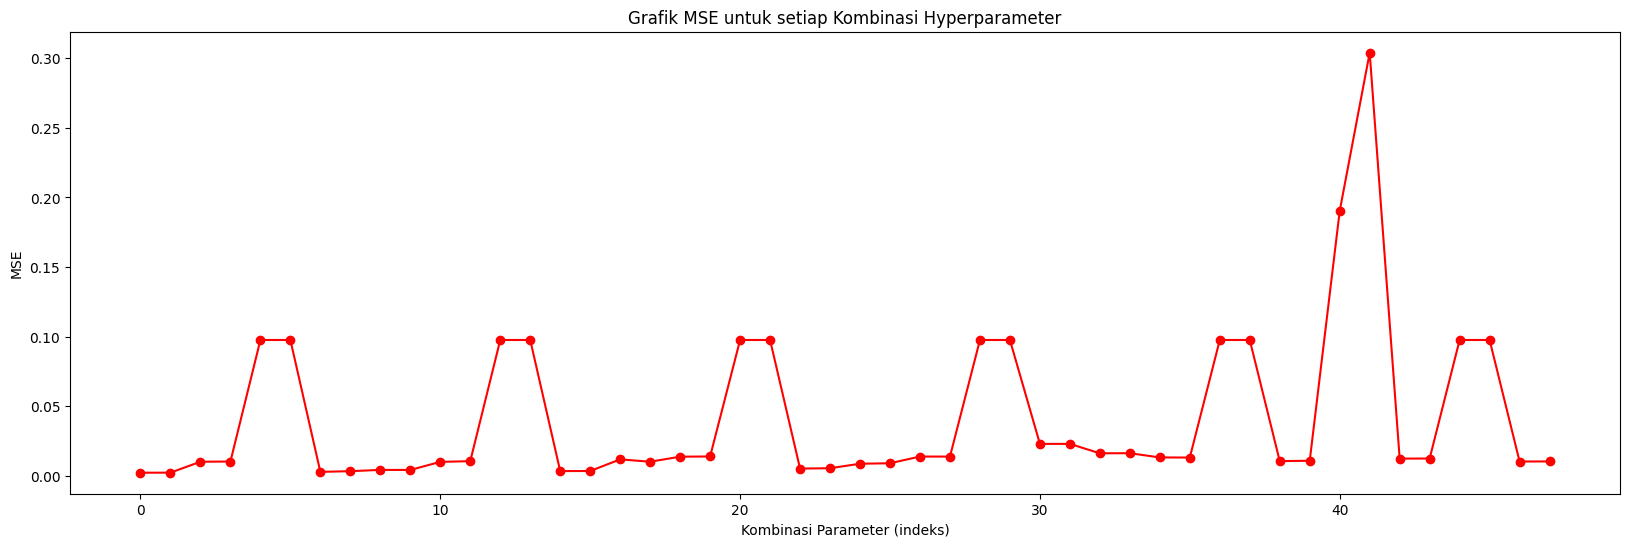

In [174]:
plt.figure(figsize=(20, 6))
plt.plot(range(len(tuning)), tuning['mse'], marker='o', linestyle='-', color='r')
plt.title('Grafik MSE untuk setiap Kombinasi Hyperparameter')
plt.xlabel('Kombinasi Parameter (indeks)')
plt.ylabel('MSE')
plt.show()

In [175]:
tuning.to_csv('hasiltuning.csv', index=False)

In [176]:
tuning

,hidden_layer,hidden_neuron,aktivasi,lr,epoch,mse,bobot,bias,bobot_output,bias_output
0,1,"(2,)",tanh,0.0001,100,0.002281,"[[[2.4476253166650412, 0.6216495446732114], [1...","[[0.07011003544269512, -0.28833069096022335]]","[0.06739818013574604, 0.888606079185931]",0.463216
1,1,"(2,)",tanh,0.0001,200,0.002340,"[[[2.4476253166650412, 0.6216495446732114], [1...","[[0.07011003544269512, -0.28833069096022335]]","[0.06739818013574604, 0.888606079185931]",0.463319
2,1,"(2,)",tanh,0.0001,100,0.010176,"[[[2.4476253166650412, 0.6216495446732114], [1...","[[0.07011003544269512, -0.28833069096022335]]","[0.06739818013574604, 0.888606079185931]",0.463320
3,1,"(2,)",tanh,0.0001,200,0.010321,"[[[2.4476253166650412, 0.6216495446732114], [1...","[[0.07011003544269512, -0.28833069096022335]]","[0.06739818013574604, 0.888606079185931]",0.463319
4,1,"(2,)",tanh,0.0001,100,0.097626,"[[[2.4476253166650412, 0.6216495446732114], [1...","[[0.07011003544269512, -0.28833069096022335]]","[0.06739818013574604, 0.888606079185931]",0.463319
5,1,"(2,)",tanh,0.0001,200,0.097626,"[[[2.4476253166650412, 0.6216495446732114], [1...","[[0.07011003544269512, -0.28833069096022335]]","[0.06739818013574604, 0.888606079185931]",0.463319
6,1,"(2,)",tanh,0.0001,100,0.002897,"[[[2.4476253166650412, 0.6216495446732114], [1...","[[0.07011003544269512, -0.28833069096022335]]","[0.06739818013574604, 0.888606079185931]",0.463324
7,1,"(2,)",tanh,0.0001,200,0.003397,"[[[2.4476253166650412, 0.6216495446732114], [1...","[[0.07011003544269512, -0.28833069096022335]]","[0.06739818013574604, 0.888606079185931]",0.463319
8,1,"(2,)",tanh,0.0010,100,0.004313,"[[[2.4476253166650412, 0.6216495446732114], [1...","[[0.07011003544269512, -0.28833069096022335]]","[0.06739818013574604, 0.888606079185931]",0.470035
9,1,"(2,)",tanh,0.0010,200,0.004258,"[[[2.4476253166650412, 0.6216495446732114], [1...","[[0.07011003544269512, -0.28833069096022335]]","[0.06739818013574604, 0.888606079185931]",0.463330


In [177]:
best_index = tuning['mse'].idxmin()
best_hidden_layer_global = tuning['hidden_layer'][best_index]
best_hidden_neuron_global = tuning['hidden_neuron'][best_index]
best_lr_global = tuning['lr'][best_index]
best_epoch_global = tuning['epoch'][best_index]
best_mse_global = tuning['mse'][best_index]
best_bobot_global = tuning['bobot'][best_index]
best_bias_global = tuning['bias'][best_index]
best_bobot_output_global = tuning['bobot_output'][best_index]
best_bias_output_global = tuning['bias_output'][best_index]

print("Best Index:", best_index)
print("Best Hidden Layer:", best_hidden_layer_global)
print("Best Hidden Neuron:", best_hidden_neuron_global)
print("Best Learning Rate:", best_lr_global)
print("Best Epoch:", best_epoch_global)
print("Best MSE:", best_mse_global)
print("Best Bobot:", best_bobot_global)
print("Best Bias:", best_bias_global)
print("Best Bobot Output:", best_bobot_output_global)
print("Best Bias Output:", best_bias_output_global)

Best Index: 0
Best Hidden Layer: 1
Best Hidden Neuron: (2,)
Best Learning Rate: 0.0001
Best Epoch: 100
Best MSE: 0.002281238655891336
Best Bobot: [[[np.float64(2.4476253166650412), np.float64(0.6216495446732114)], [np.float64(1.404521387017017), np.float64(0.3683891779589411)], [np.float64(2.0798762010171665), np.float64(0.1227406091613603)], [np.float64(0.941023055428894), np.float64(0.18767291951916715)]]]
Best Bias: [[0.07011003544269512, np.float64(-0.28833069096022335)]]
Best Bobot Output: [np.float64(0.06739818013574604), np.float64(0.888606079185931)]
Best Bias Output: 0.4632157628328146
